# Implementing a k fold validation to obtain results that can be directly related to multinomial logistic regression

In [4]:
#Libraries for math and data manipulation
import numpy as np
import pandas as pd
import math
import numpy.random as rand
import scipy as sp
import sys
from datetime import datetime

#Plotting stuff
import matplotlib.pyplot as plt
import seaborn
import corner
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True) #Want to be able to use tex in the plot labels
seaborn.set_style('ticks')
seaborn.set_color_codes()

#Machine learning stuff
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier   #This is a single decision tree
from sklearn.ensemble import ExtraTreesClassifier #Random forest of trees
import graphviz                                   #This package lets you visualize the tree
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.model_selection import train_test_split

In [507]:
#Read in Stata datafile
#data_stata = pd.io.stata.read_stata('../ProjectDef/cnsfinall2.dta')
#Convert to .csv. Now you never need to do this again
#data_stata.to_csv('../Data/cns_data.csv')

In [5]:
data_raw = pd.read_csv("../Data/cns_data.csv")   #Using Pandas for data manipulation

In [6]:
#Delete useless columns (like surename, initials, etc.)
data_df = data_raw.drop(['surnamenam','patinit','patientreg','mothinit'],axis=1)

Here are the actual diagnoses:

In [7]:
data_df.diag.unique()

array(['malaria', '0.0', 'cereb malaria', 'virus-bacteria', 'bacteremia',
       'bact meningitis', 'virus-other', 'virus-malaria',
       'malaria-bacterial', 'tb', 'virus', 'crypto'], dtype=object)

In [511]:
#Adding a variable that is just 'month and day' - seems better to capture seasonality.
data_df['month'] = pd.DatetimeIndex(data_df['incdate']).month
data_df['day'] = pd.DatetimeIndex(data_df['incdate']).day
data_df['monthday'] = data_df['month']*30+data_df['day']

In [512]:
#sum(clin_df['incirrit'] == "Don't know")

In [513]:
#Select input features
#6-8 adding inclusion criteria and rdttest MLW
clin_df = data_df.loc[:,['glasgtot','blanttot','clinjaund','clinhepato','clinspleno','clinconv','clindehyd',\
                          'clinoedem','clinlymph','clinresp','clinablung','clincyan','clincapref','clincoldext',\
                         'clinearinf','clinanemia','clintonsil','clinorcand','clinhemmor','clinaids',\
                         'abdpain','vom','diar','head','muscle','conv',\
                         'sex','ageyrs','agemth','incdate',\
                         'temp','card','resp','sbp','dbp','weight','height','muac',\
                          'mhhosp', 'mhdevsp', 'mhsickle', 'mhchronstat',\
                         'monthday','dimain', \
                         'incirrit', 'inchead', 'incphoto',\
                         'incfont', 'incneuro' , 'incseiza', 'incseizh',\
                          'incpurp','diag']] #This is the final diagnosis - will be the 'label'

In [514]:
#Convert the date into a useful value. This just counts the days from the beginning of the dataset 
clin_df['incdate'] = pd.to_datetime(clin_df['incdate'])
clin_df['date'] = (clin_df['incdate'] - clin_df['incdate'].min())  / np.timedelta64(1,'D')

#Mapping yes/no to 1/0
clin_df['clinjaund'] = clin_df.clinjaund.map({'Yes': 1, 'No': 0})
clin_df['clinhepato'] = clin_df.clinhepato.map({'Yes': 1, 'No': 0})
clin_df['clinspleno'] = clin_df.clinspleno.map({'Yes': 1, 'No': 0})
clin_df['clinconv'] = clin_df.clinconv.map({'Yes': 1, 'No': 0})
clin_df['clindehyd'] = clin_df.clindehyd.map({'Yes': 1, 'No': 0})
clin_df['clinoedem'] = clin_df.clinoedem.map({'Yes': 1, 'No': 0})
clin_df['clinlymph'] = clin_df.clinlymph.map({'Yes': 1, 'No': 0})
clin_df['clinresp'] = clin_df.clinresp.map({'Yes': 1, 'No': 0})
clin_df['clinablung'] = clin_df.clinablung.map({'Yes': 1, 'No': 0})
clin_df['clincyan'] = clin_df.clincyan.map({'Yes': 1, 'No': 0})
clin_df['clincapref'] = clin_df.clincapref.map({'Yes': 1, 'No': 0})
clin_df['clincoldext'] = clin_df.clincoldext.map({'Yes': 1, 'No': 0})
clin_df['clinearinf'] = clin_df.clinearinf.map({'Yes': 1, 'No': 0})
clin_df['clintonsil'] = clin_df.clintonsil.map({'Yes': 1, 'No': 0})
clin_df['clinorcand'] = clin_df.clinorcand.map({'Yes': 1, 'No': 0})
clin_df['clinhemmor'] = clin_df.clinhemmor.map({'Yes': 1, 'No': 0})
clin_df['clinaids'] = clin_df.clinaids.map({'Yes': 1, 'No': 0})
clin_df['vom'] = clin_df.vom.map({'Yes': 1, 'No': 0})
clin_df['diar'] = clin_df.diar.map({'Yes': 1, 'No': 0})
clin_df['headache'] = clin_df['head'] #Since 'head' is a function
clin_df['conv'] = clin_df.conv.map({'Yes': 1, 'No': 0})
clin_df['ageym'] = clin_df.ageyrs.astype(float)*12.
clin_df.agemth = clin_df.agemth.astype(float)
clin_df['age'] = clin_df.ageym + clin_df.agemth


#Medical history variables
clin_df['mhhosp'] = clin_df.mhhosp.map({'Yes': 1, 'No':0})


#some slightly more compliated mappings
clin_df['abdpain'] = clin_df.abdpain.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':np.nan})
clin_df['headache'] = clin_df.headache.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['muscle'] = clin_df.muscle.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':np.nan})

clin_df['dimain'] = clin_df.dimain.map({"Cerebral Malaria":0, "Meningoencephalitis":1, "Meningitis":2.,\
                                       "Other":3})

clin_df['mhdevsp'] = clin_df.mhdevsp.map({'OTHER':1, 'GLOBAL DEVELOPMENTAL DELAY':1, 'HYDROCEPHALUS':1,
       'HEARING LOSSES':1, 'MOTOR DEVELOPEMENTAL DELAY':1,
       'SPEECH DEVELOPEMENTAL DELAY':1})

#Mapping of inclusion variables 6-8 MLW
clin_df['incirrit'] = clin_df.incirrit.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['inchead'] = clin_df.inchead.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['incphoto'] = clin_df.incphoto.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['incfont'] = clin_df.incfont.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['incneuro'] = clin_df.incneuro.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['incseiza'] = clin_df.incseiza.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['incseizh'] = clin_df.incseizh.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['incpurp'] = clin_df.incpurp.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})


#This coding is going to be important. You'll want to figure out which categories are useful, and which
#are practical.
clin_df['diag'] = clin_df.diag.map({'malaria':0, 'cereb malaria':0,'virus-malaria':0,\
                                    'virus-bacteria':1, 'bacteremia':1,'bact meningitis':1,\
                                    'virus-other':2,'virus':2,'malaria-bacterial':3,\
                                    'tb':4,'crypto':4, '0.0':5})

In [515]:
#A lot of these have very few actual answers. i.e., 'headache.' What happens if you map 'nan' to 'No'?
#This is probably something we'll want to play around with.
values = {'clinjaund':0,'clinhepato':0,'clinaids':0,'clinhemmor':0,'clinorcand':0,'clintonsil':0,'clinearinf':0,\
          'clinresp':0,'clinlymph':0,'clindehyd':0,'clinoedem':0,'clinablung':0,'clincyan':0,'clincapref':0,
          'clincoldext':0, 'mhchronstat':0, 'mhdevsp':0,\
         'conv':0,'abdpain':0,'vom':0,'diar':0,'headache':0,'muscle':0}
clin_df = clin_df.fillna(value=values)

In [516]:
#You really shouldn't use the initial diagnosis as a continuous variable ,
#you need to map it into a set of yes/no question.
clin_df['CMalaria'] = clin_df.dimain.map({0:1,1:0,2:0,3:0})
clin_df['Enceph'] = clin_df.dimain.map({0:0,1:1,2:0,3:0})
clin_df['Mening'] = clin_df.dimain.map({0:0,1:0,2:1,3:0})
clin_df['Other'] = clin_df.dimain.map({0:0,1:0,2:0,3:1})

print(clin_df.dimain.unique())

[0. 1. 2. 3.]


In [517]:
#Pick the features to classify with.
Xlabels = ['CMalaria','Enceph','Mening','Other',\
                      'headache','age','temp','date',\
                      'clinjaund','clintonsil','clinhepato','clinaids','clinhemmor','clinorcand','clinearinf',\
                      'clinresp','clinlymph','clindehyd','clinoedem','clinablung','clincyan','clincapref',\
                      'glasgtot', 'dbp', 'sbp','resp','card','weight','height','muac',\
                      'mhhosp','mhchronstat', 'mhdevsp',\
                      'conv','abdpain','vom','diar','muscle','monthday',\
                      'incirrit', 'inchead', 'incphoto',\
                      'incfont', 'incneuro' , 'incseiza', 'incseizh',\
                      'incpurp'] #This is just for plotting.
X_pd = clin_df.loc[:,['CMalaria','Enceph','Mening','Other',\
                      'headache','age','temp','date',\
                      'clinjaund','clintonsil','clinhepato','clinaids','clinhemmor','clinorcand','clinearinf',\
                      'clinresp','clinlymph','clindehyd','clinoedem','clinablung','clincyan','clincapref',\
                      'glasgtot', 'dbp', 'sbp','resp','card','weight','height','muac',\
                      'mhhosp','mhchronstat', 'mhdevsp',\
                      'conv','abdpain','vom','diar','muscle','monthday',\
                       'incirrit', 'inchead', 'incphoto',\
                      'incfont', 'incneuro' , 'incseiza', 'incseizh',\
                      'incpurp','diag']]
X_pd = X_pd.dropna()  #Drop cases that have nan for *any* entry

In [518]:
#Get things into the correct format for scikit-learn. I've tried to use the convention throughout that variables
#ending in 'pd' are pandas dataframes.
Input = X_pd.as_matrix()        #creates a numpy array
Features = Input[:,0:-1].copy() #separate the features and labels
Labels = Input[:,-1].copy()
ncase = len(Input[:,0])
print(ncase)                     #checking that there are a reasonable number of cases left

361


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [519]:
# Keep patient IDs for later sorting
Features = np.append(Features, np.zeros((361,1)), axis=1)
Features[:,47]=X_pd.index

In [520]:
X = Features.copy()  #changing to X and y. For no real reason
y = Labels.copy()

In [ ]:
#skl will split the data into training and test for you. Right now, I'm training on 2/3 of the data.
X_train_index, X_test_index, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train = X_train_index[:,0:-1].copy()# Get rid of patient Ids for the algorithm
X_test = X_test_index[:,0:-1].copy()
X_train_index = X_train_index[:,-1].copy() #Keep patient IDs here
X_test_index = X_test_index[:,-1].copy()
print(np.shape(X_train))

In [522]:
#Actual classifier. This is doing n_estimators trees, up to max_depth cuts. Something to play with.
forest = ExtraTreesClassifier(n_estimators=20,
                              random_state=0,max_depth=50 )

#Fit the classifier.
forest.fit(X_train, y_train)

#extract the 'importances' of the features
importances = forest.feature_importances_
#calculate standard deviation
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

Feature ranking:
1. feature 0 (0.101819)
2. feature 2 (0.054643)
3. feature 1 (0.045922)
4. feature 22 (0.044878)
5. feature 24 (0.040474)
6. feature 25 (0.039368)
7. feature 29 (0.038060)
8. feature 26 (0.037654)
9. feature 7 (0.036647)
10. feature 27 (0.036520)


ValueError: shape mismatch: objects cannot be broadcast to a single shape

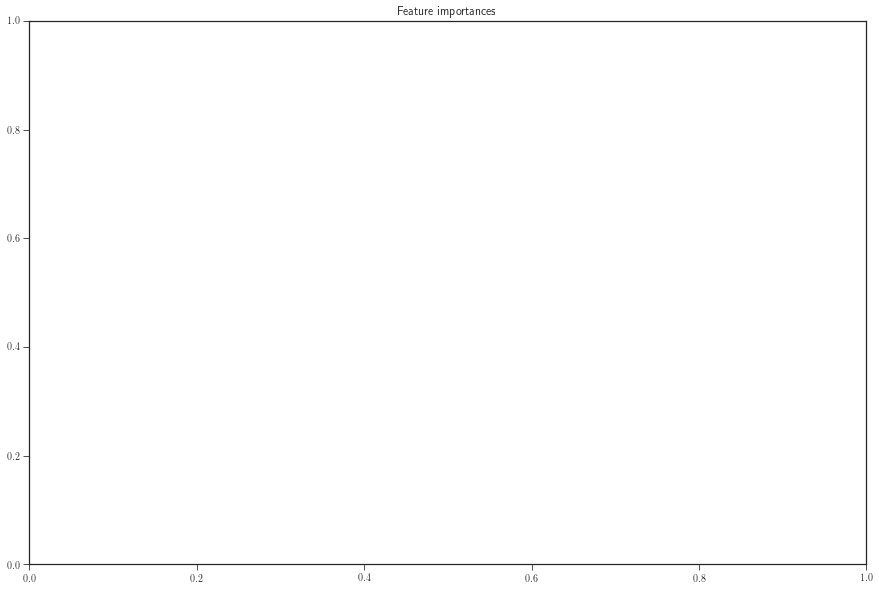

In [523]:
# Print the feature ranking
Xlabels = np.array(Xlabels)
PlotLabels = Xlabels[indices]
print("Feature ranking:")
#for full feature listing use this as the range: X.shape[1]
for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), PlotLabels, rotation='vertical',fontsize=15)
plt.xlim([-1, X.shape[1]])
plt.ylim(0,0.15)
plt.show()

In [524]:
#Make the predictions on the test data
y_pred_prob = forest.predict_proba(X_test)
y_pred = forest.predict(X_test)

In [525]:
#Print the confusion matrix:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[37  2  0  0  9]
 [ 1  4  0  0 14]
 [ 0  1  0  0  4]
 [ 2  0  0  0  0]
 [ 8  4  0  0 34]]
             precision    recall  f1-score   support

        0.0       0.77      0.77      0.77        48
        1.0       0.36      0.21      0.27        19
        2.0       0.00      0.00      0.00         5
        3.0       0.00      0.00      0.00         2
        5.0       0.56      0.74      0.64        46

avg / total       0.58      0.62      0.59       120



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [526]:
#Because this is a random forest, the output is actually a probability of being in each class. So this is looking
#at the maximum probability for each test case - it gives us a sense of how confident the classifier is in each
#
probmax = np.amax(y_pred_prob,axis=1)
edges = np.linspace(0,1,101)

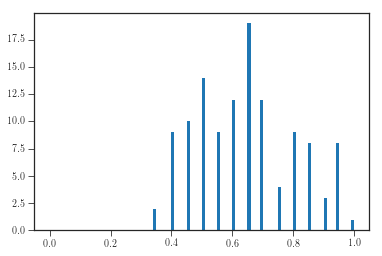

In [527]:
a,b,c = plt.hist(probmax,bins=edges)

In [528]:
'''
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data)
graph.render("iris")
'''

'\ndot_data = tree.export_graphviz(clf, out_file=None) \ngraph = graphviz.Source(dot_data)\ngraph.render("iris")\n'

In [529]:
# Save results for comparison
df = pd.DataFrame(X_test, columns=['CMalaria','Enceph','Mening','Other',\
                      'headache','age','temp','date',\
                      'clinjaund','clintonsil','clinhepato','clinaids','clinhemmor','clinorcand','clinearinf',\
                      'clinresp','clinlymph','clindehyd','clinoedem','clinablung','clincyan','clincapref',\
                      'glasgtot', 'dbp', 'sbp','resp','card','weight','height','muac',\
                      'mhhosp','mhchronstat', 'mhdevsp',\
                      'conv','abdpain','vom','diar','muscle','monthday',\
                       'incirrit', 'inchead', 'incphoto',\
                      'incfont', 'incneuro' , 'incseiza', 'incseizh',\
                      'incpurp'])
results = pd.DataFrame(columns=['patientid','diag','rfpred'])
results['patientid'] = X_test_index
results['diag'] = y_test
results['rfpred'] = y_pred
results = pd.concat([results,df], sort=False, axis = 1)
results.shape

(120, 50)

In [530]:
X_all = np.append(X_train,X_test,axis = 0) #put features and labels back together with test on the end
y_all = np.append(y_train,y_test, axis = 0)
y_test = y_all[0:120] #make new y_test and y_train groups
y_train = y_all[120:361]

In [531]:
X_test = X_all[0:120,:] #make new x_test and X_train
X_train = X_all[120:361,:]

In [532]:
X_all_index = np.append(X_train_index,X_test_index, axis = 0)
X_test_index = X_all_index[0:120] #make indices again
X_train_index = X_all_index[120:361]

In [533]:
#Run through ML classification again

In [534]:
#Actual classifier. This is doing n_estimators trees, up to max_depth cuts. Something to play with.
forest = ExtraTreesClassifier(n_estimators=20,
                              random_state=0,max_depth=50 )

#Fit the classifier.
forest.fit(X_train, y_train)

#extract the 'importances' of the features
importances = forest.feature_importances_
#calculate standard deviation
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

Feature ranking:
1. feature 0 (0.114401)
2. feature 2 (0.058820)
3. feature 1 (0.044669)
4. feature 22 (0.042100)
5. feature 10 (0.040405)
6. feature 29 (0.039122)
7. feature 7 (0.038979)
8. feature 28 (0.038297)
9. feature 27 (0.035146)
10. feature 6 (0.034695)


ValueError: shape mismatch: objects cannot be broadcast to a single shape

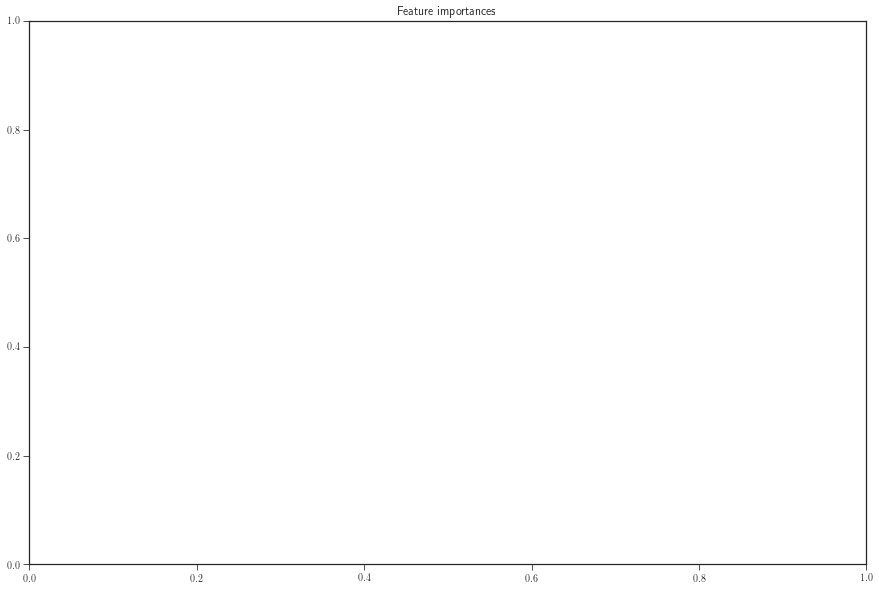

In [535]:
# Print the feature ranking
Xlabels = np.array(Xlabels)
PlotLabels = Xlabels[indices]
print("Feature ranking:")
#for full feature listing use this as the range: X.shape[1]
for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), PlotLabels, rotation='vertical',fontsize=15)
plt.xlim([-1, X.shape[1]])
plt.ylim(0,0.15)
plt.show()

In [536]:
#Make the predictions on the test data
y_pred_prob = forest.predict_proba(X_test)
y_pred = forest.predict(X_test)

In [537]:
#Print the confusion matrix:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[29  2  0  0  0  6]
 [ 3  6  1  0  0  8]
 [ 0  0  0  0  0  1]
 [ 4  0  0  0  0  0]
 [ 0  0  0  0  0  3]
 [ 8 12  1  0  0 36]]
             precision    recall  f1-score   support

        0.0       0.66      0.78      0.72        37
        1.0       0.30      0.33      0.32        18
        2.0       0.00      0.00      0.00         1
        3.0       0.00      0.00      0.00         4
        4.0       0.00      0.00      0.00         3
        5.0       0.67      0.63      0.65        57

avg / total       0.56      0.59      0.58       120



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [538]:
#Because this is a random forest, the output is actually a probability of being in each class. So this is looking
#at the maximum probability for each test case - it gives us a sense of how confident the classifier is in each
#
probmax = np.amax(y_pred_prob,axis=1)
edges = np.linspace(0,1,101)

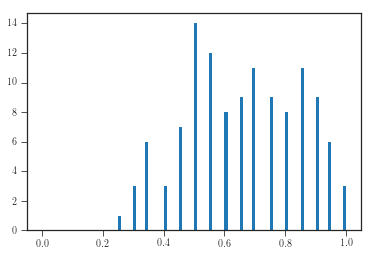

In [539]:
a,b,c = plt.hist(probmax,bins=edges)

In [540]:
# Save results for comparison
df = pd.DataFrame(X_test, columns=['CMalaria','Enceph','Mening','Other',\
                      'headache','age','temp','date',\
                      'clinjaund','clintonsil','clinhepato','clinaids','clinhemmor','clinorcand','clinearinf',\
                      'clinresp','clinlymph','clindehyd','clinoedem','clinablung','clincyan','clincapref',\
                      'glasgtot', 'dbp', 'sbp','resp','card','weight','height','muac',\
                      'mhhosp','mhchronstat', 'mhdevsp',\
                      'conv','abdpain','vom','diar','muscle','monthday',\
                       'incirrit', 'inchead', 'incphoto',\
                      'incfont', 'incneuro' , 'incseiza', 'incseizh',\
                      'incpurp'])
results2 = pd.DataFrame(columns=['patientid','diag','rfpred'])
results2['patientid'] = X_test_index
results2['diag'] = y_test
results2['rfpred'] = y_pred
results2 = pd.concat([results2,df], sort=False, axis = 1)
results2.shape

(120, 50)

In [541]:
X_all = np.append(X_train,X_test,axis = 0) #put features and labels back together with test on the end
y_all = np.append(y_train,y_test, axis = 0)
y_test = y_all[0:121] #make new y_test and y_train groups
y_train = y_all[121:361]

In [542]:
X_test = X_all[0:121,:] #make new x_test and X_train
X_train = X_all[121:361,:]

In [543]:
X_all_index = np.append(X_train_index,X_test_index, axis = 0)
X_test_index = X_all_index[0:121] #make indices again
X_train_index = X_all_index[121:361]

In [544]:
#Run through ML classification again

In [545]:
#Actual classifier. This is doing n_estimators trees, up to max_depth cuts. Something to play with.
forest = ExtraTreesClassifier(n_estimators=20,
                              random_state=0,max_depth=50 )

#Fit the classifier.
forest.fit(X_train, y_train)

#extract the 'importances' of the features
importances = forest.feature_importances_
#calculate standard deviation
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

Feature ranking:
1. feature 0 (0.078024)
2. feature 1 (0.066259)
3. feature 22 (0.053269)
4. feature 2 (0.046522)
5. feature 23 (0.042203)
6. feature 5 (0.039924)
7. feature 29 (0.037073)
8. feature 26 (0.036597)
9. feature 27 (0.036395)
10. feature 25 (0.036116)


ValueError: shape mismatch: objects cannot be broadcast to a single shape

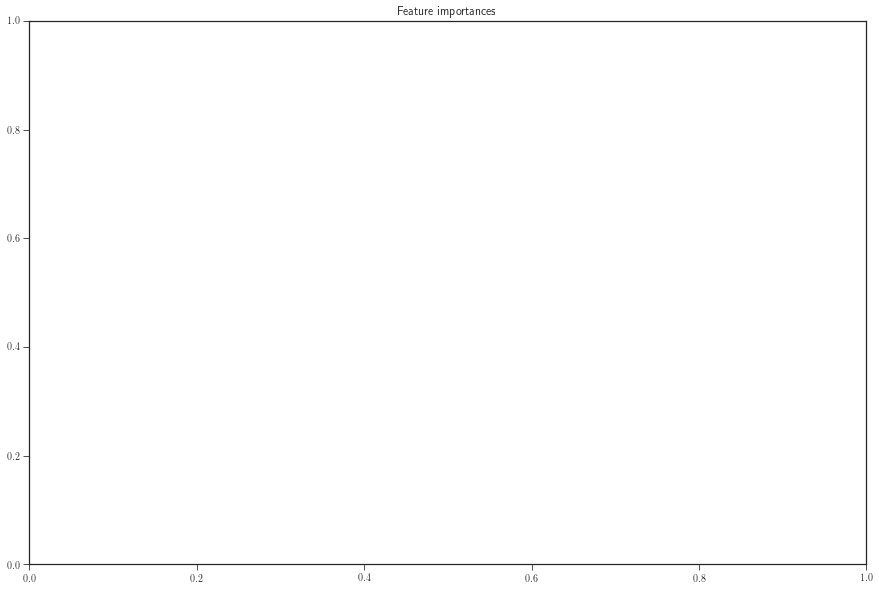

In [546]:
# Print the feature ranking
Xlabels = np.array(Xlabels)
PlotLabels = Xlabels[indices]
print("Feature ranking:")
#for full feature listing use this as the range: X.shape[1]
for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), PlotLabels, rotation='vertical',fontsize=15)
plt.xlim([-1, X.shape[1]])
plt.ylim(0,0.15)
plt.show()

In [547]:
#Make the predictions on the test data
y_pred_prob = forest.predict_proba(X_test)
y_pred = forest.predict(X_test)

In [548]:
#Print the confusion matrix:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[37  0  0  1  0  4]
 [ 4  2  0  0  0 15]
 [ 1  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  1  0  0  0  1]
 [17  3  0  0  0 35]]
             precision    recall  f1-score   support

        0.0       0.63      0.88      0.73        42
        1.0       0.33      0.10      0.15        21
        2.0       0.00      0.00      0.00         1
        3.0       0.00      0.00      0.00         0
        4.0       0.00      0.00      0.00         2
        5.0       0.64      0.64      0.64        55

avg / total       0.56      0.61      0.57       121



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [549]:
#Because this is a random forest, the output is actually a probability of being in each class. So this is looking
#at the maximum probability for each test case - it gives us a sense of how confident the classifier is in each
#
probmax = np.amax(y_pred_prob,axis=1)
edges = np.linspace(0,1,101)

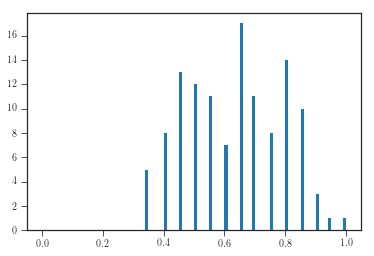

In [550]:
a,b,c = plt.hist(probmax,bins=edges)

In [551]:
# Save results for comparison
df = pd.DataFrame(X_test, columns=['CMalaria','Enceph','Mening','Other',\
                      'headache','age','temp','date',\
                      'clinjaund','clintonsil','clinhepato','clinaids','clinhemmor','clinorcand','clinearinf',\
                      'clinresp','clinlymph','clindehyd','clinoedem','clinablung','clincyan','clincapref',\
                      'glasgtot', 'dbp', 'sbp','resp','card','weight','height','muac',\
                      'mhhosp','mhchronstat', 'mhdevsp',\
                      'conv','abdpain','vom','diar','muscle','monthday',\
                       'incirrit', 'inchead', 'incphoto',\
                      'incfont', 'incneuro' , 'incseiza', 'incseizh',\
                      'incpurp'])
results3 = pd.DataFrame(columns=['patientid','diag','rfpred'])
results3['patientid'] = X_test_index
results3['diag'] = y_test
results3['rfpred'] = y_pred
results3 = pd.concat([results3,df], sort=False, axis = 1)
results3.shape

(121, 50)

In [552]:
rf_results = results.append(results2).append(results3)

In [553]:
rf_results.shape

(361, 50)

In [554]:
#Write results for use in other notebooks
rf_results.to_csv("Outputs/rf_results.csv")